# Siamese One-Shot-Learning Network, [Fruits 360](https://www.kaggle.com/moltean/fruits) Using [PyTorch](https://pytorch.org)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Set Configs

In [4]:
TRAIN_DIR = './datasets/fruits/training/'
TEST_DIR = './datasets/fruits/testing/'
BATCH_SIZE = 64
N_EPOCHS = 20
LR = 0.0005
N_GPU = 1
SET_L = True
INPUT_D = 3 if SET_L == False else 1

In [5]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and N_GPU > 0) else 'cpu')

## Set Helpers

In [6]:
def show_img(img, text=None, figsize=(20,20), save_into=None):
    
    img = img.numpy()
    plt.figure(figsize=figsize)
    plt.axis('off')
    if text:
        plt.text(50, 8, text, bbox={'facecolor': 'white', 'alpha': 1 })
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
    if save_into: 
        if not os.path.exists('./images/fruits/'): os.makedirs('./images/fruits/')
        plt.savefig(save_into)
        plt.show()
    else:
        plt.show()

## Configure Custom Data Loader

In [7]:
class SiameseDataset(torch.utils.data.Dataset):
    
    def __init__(self, datasets, train=True, transform=None, should_invert=True, set_luminance=True):
        self.datasets = datasets
        self.train = train
        self.transform = transform
        self.should_invert = should_invert
        self.set_luminance = set_luminance
        
    def __getitem__(self, index):
        
        imageA_tupple = random.choice(self.datasets.imgs)
        get_same_class = random.randint(0,1)
        if get_same_class:
            while True:
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] == imageB_tupple[1]:
                    break
        else:
            while True:
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] != imageB_tupple[1]:
                    break
                    
        imageA = Image.open(imageA_tupple[0])
        imageB = Image.open(imageB_tupple[0])
        
        if self.set_luminance:
            imageA = imageA.convert('L')
            imageB = imageB.convert('L')
        
        if self.should_invert:
            imageA = ImageOps.invert(imageA)
            imageB = ImageOps.invert(imageB)
            
        if self.transform is not None:
            imageA = self.transform(imageA)
            imageB = self.transform(imageB)
        
        if self.train:
            return imageA, imageB, torch.from_numpy(np.array([int(imageA_tupple[1] != imageB_tupple[1])], dtype=np.float32))
        else:
            return imageA, imageA_tupple[0], imageA_tupple[1], imageB, imageB_tupple[0], imageB_tupple[1]
        
    def __len__(self):
        return len(self.datasets.imgs)

In [8]:
transform = transforms.Compose([
                            transforms.Resize((100,100)),
                            transforms.ToTensor(),
])

In [9]:
datasets = torchvision.datasets.ImageFolder(root=TRAIN_DIR)

In [10]:
siamese_datasets = SiameseDataset(datasets=datasets, train=True, transform=transform, should_invert=False, set_luminance=False)
data_loader = DataLoader(siamese_datasets, shuffle=True, batch_size=BATCH_SIZE)

## Visualize Data

In [11]:
example_batch = next(iter(data_loader))
print('Total Datasets:', len(datasets))
print('Batch consists {} data including image A, image B and its similarity score (label).'.format(len(example_batch)))

Total Datasets: 1627
Batch consists 3 data including image A, image B and its similarity score (label).


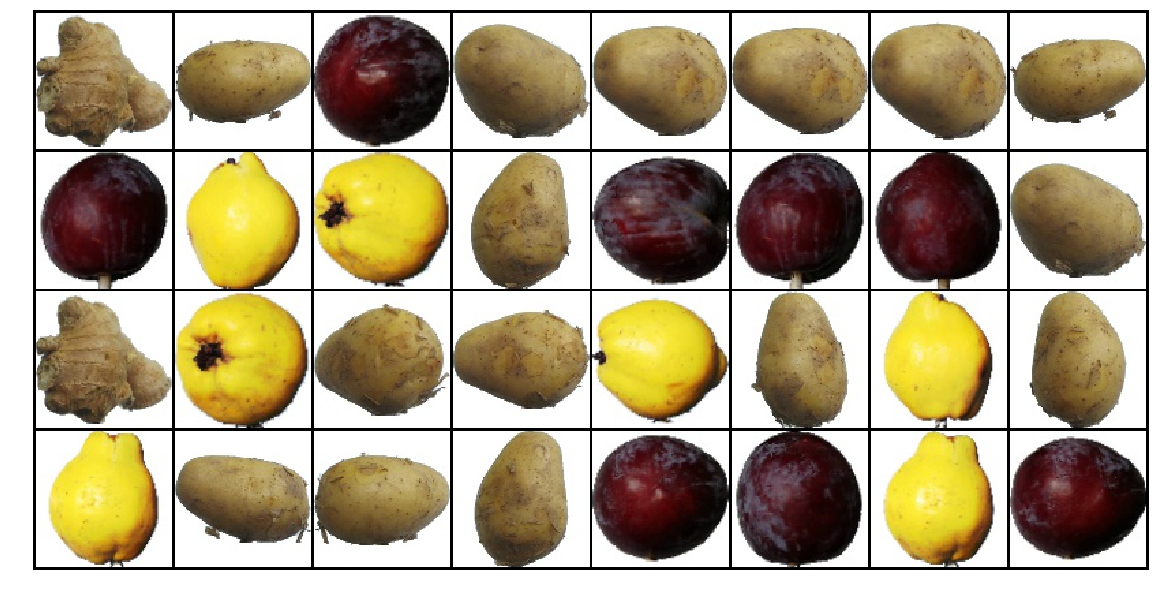

In [12]:
concatenated = torch.cat((example_batch[0][:16], example_batch[1][:16]),0)
show_img(torchvision.utils.make_grid(concatenated), save_into='./images/fruits/datasets_images.png')

## Prepare Training Data

In [13]:
siamese_datasets = SiameseDataset(datasets=datasets, transform=transform, should_invert=False, set_luminance=SET_L)
train_loader = DataLoader(siamese_datasets, shuffle=True, num_workers=0, batch_size=BATCH_SIZE)

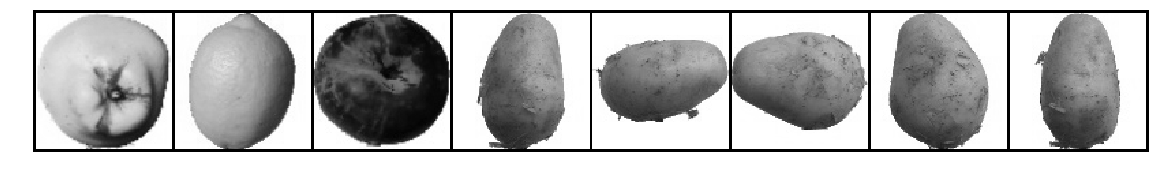

In [14]:
example_batch = next(iter(train_loader))
concatenated = torch.cat((example_batch[0][:4], example_batch[1][:4]),0)
show_img(torchvision.utils.make_grid(concatenated), save_into='./images/fruits/train_images.png')

## Build [Siamese Network](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) Architecture

In [15]:
class SiamaseNet(nn.Module):
    
    def __init__(self):
        super(SiamaseNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(INPUT_D, 4, kernel_size=3),
            nn.ReLU(),        
            nn.ZeroPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(),
            nn.ZeroPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 5),
        )
        
    def forward_once(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layer(x)
        
        return x
    
    def forward(self, imageA, imageB):
        resultA = self.forward_once(imageA)
        resultB = self.forward_once(imageB)
        
        return resultA, resultB

#### Initialize Siamese Network

In [16]:
siamese = SiamaseNet().to(device)

## Loss [Function](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

In [17]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, resultA, resultB, label):
        euclidean_distance = F.pairwise_distance(resultA, resultB, keepdim=True) # L2 Norm
        contrastive_loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + 
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return contrastive_loss

In [18]:
contrastive_loss = ContrastiveLoss()

## Set Optimizer

In [19]:
optimizer = optim.Adam(siamese.parameters(), lr=LR)

## Train The Network

In [20]:
train_loss = 0
train_loss_history = []
N = len(datasets)

for epoch in range(N_EPOCHS):
    for batch_idx, data in enumerate(train_loader):
        imageA, imageB, label = data
        imageA, imageB, label = imageA.to(device), imageB.to(device), label.to(device)
        
        optimizer.zero_grad()
        resultA, resultB = siamese(imageA, imageB)
        loss = contrastive_loss(resultA, resultB, label)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    train_loss = train_loss/(N//BATCH_SIZE)
    train_loss_history.append(train_loss)
    print('Train Epoch: {} Loss: {:.6f}'.format(epoch+1, train_loss))

    if not os.path.exists('./weights/fruits/'): os.makedirs('./weights/fruits/')
    torch.save(siamese, './weights/fruits/siamese_{:03}.pt'.format(epoch+1))

Train Epoch: 1 Loss: 1.523749
Train Epoch: 2 Loss: 0.612476
Train Epoch: 3 Loss: 0.239787
Train Epoch: 4 Loss: 0.137935
Train Epoch: 5 Loss: 0.125207
Train Epoch: 6 Loss: 0.092564
Train Epoch: 7 Loss: 0.068486
Train Epoch: 8 Loss: 0.072976
Train Epoch: 9 Loss: 0.051040
Train Epoch: 10 Loss: 0.041534
Train Epoch: 11 Loss: 0.036767
Train Epoch: 12 Loss: 0.032453
Train Epoch: 13 Loss: 0.030311
Train Epoch: 14 Loss: 0.032248
Train Epoch: 15 Loss: 0.027998
Train Epoch: 16 Loss: 0.021902
Train Epoch: 17 Loss: 0.021640
Train Epoch: 18 Loss: 0.024009
Train Epoch: 19 Loss: 0.036396
Train Epoch: 20 Loss: 0.021543


## Evaluate The Network

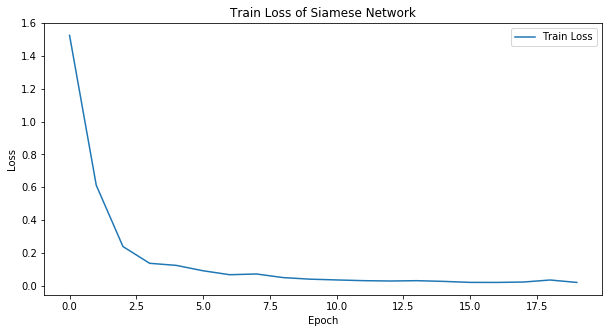

In [21]:
plt.figure(figsize=(10,5))
plt.title("Train Loss of Siamese Network")
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/fruits/'): os.makedirs('./images/fruits/')
plt.savefig('./images/fruits/final_train_loss.png')
plt.show()

In [22]:
class_list = os.listdir('./datasets/fruits/testing/')
class_list.sort()

datasets = torchvision.datasets.ImageFolder(root=TEST_DIR)
siamese_datasets = SiameseDataset(datasets=datasets, train=False, transform=transform, 
                                  should_invert=False, set_luminance=SET_L)

In [23]:
test_loader = DataLoader(siamese_datasets, num_workers=0, batch_size=1, shuffle=True)
data_iter = iter(test_loader)
imageA, pathA, classA, _, _, _ = next(data_iter)

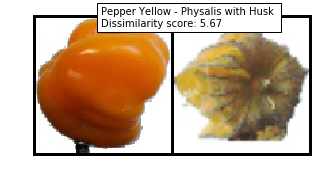

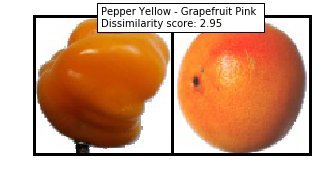

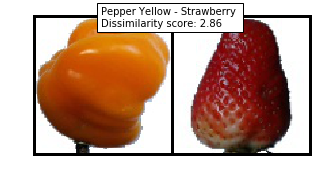

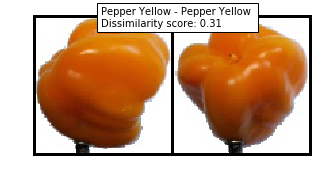

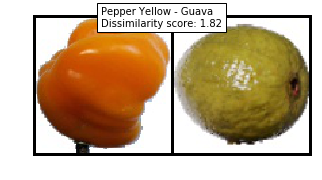

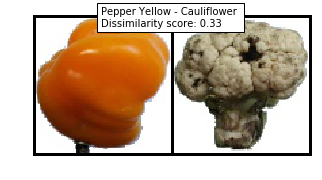

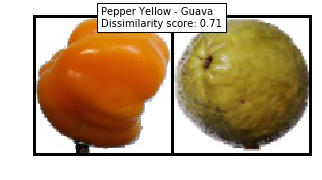

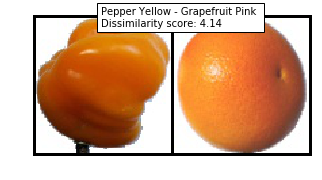

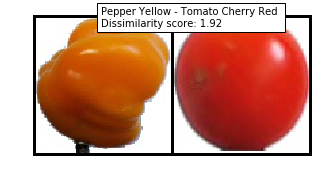

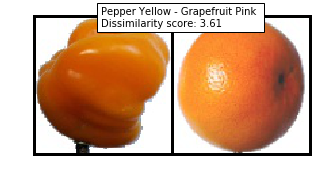

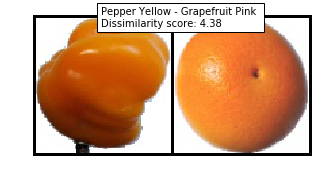

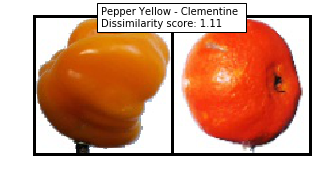

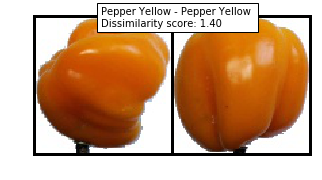

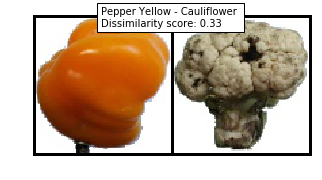

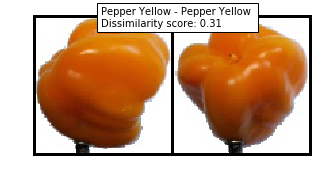

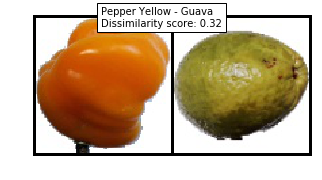

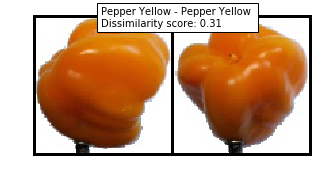

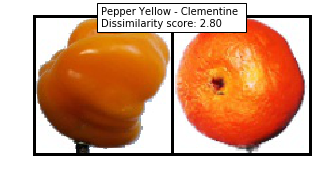

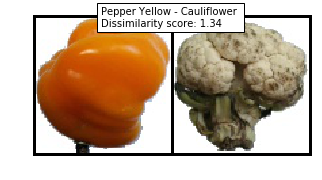

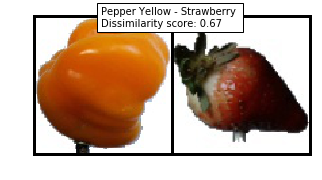

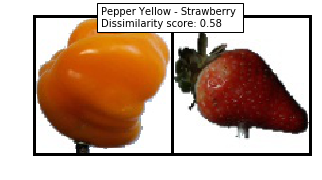

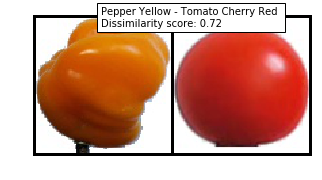

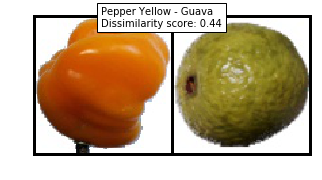

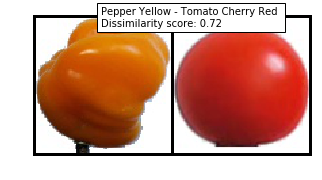

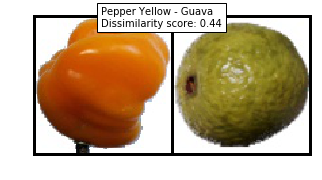

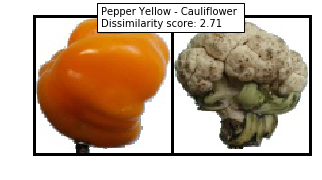

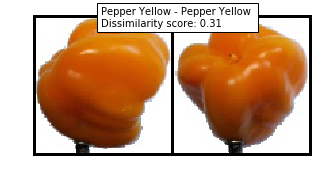

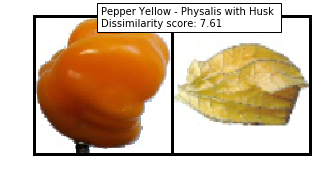

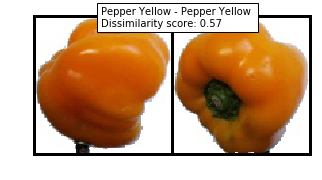

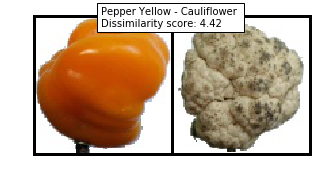

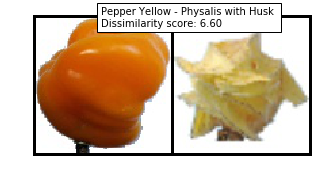

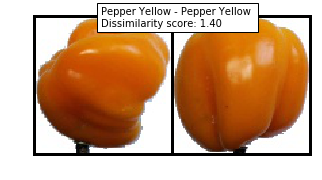

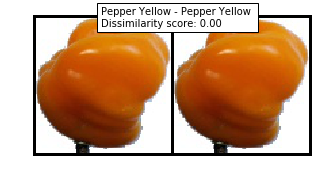

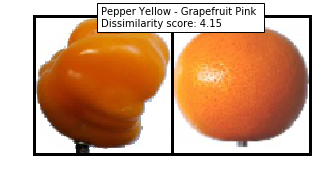

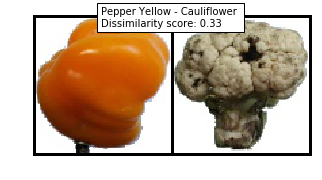

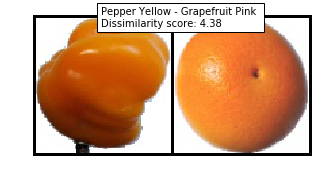

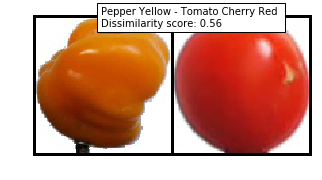

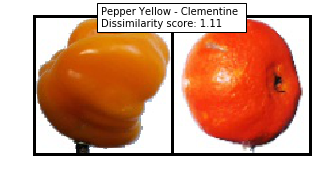

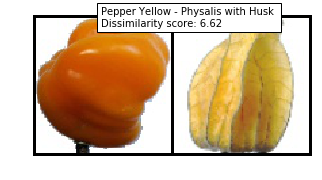

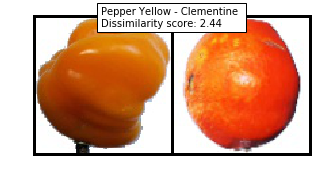

In [24]:
test_loader = DataLoader(siamese_datasets, num_workers=0, batch_size=1, shuffle=True)
data_iter = iter(test_loader)
for i in range(len(datasets)):
    _, _, _, imageB, pathB, classB = next(data_iter)
    
    with torch.no_grad():
        resultA, resultB = siamese(Variable(imageA).to(device), Variable(imageB).to(device))
        euclidean_distance = F.pairwise_distance(resultA, resultB)
    
    # recolour input images
    imageA_ = np.expand_dims(np.transpose(np.array(Image.open(pathA[0])), (2, 0, 1)), axis=0)
    imageA_ = torch.tensor(imageA_)
    imageB_ = np.expand_dims(np.transpose(np.array(Image.open(pathB[0])), (2, 0, 1)), axis=0)
    imageB_ = torch.tensor(imageB_)
    
    concatenated = torch.cat((imageA_, imageB_),0)
    show_img(torchvision.utils.make_grid(concatenated), '{} - {} \nDissimilarity score: {:.2f}'.format(class_list[classA.item()], 
                                                                                                       class_list[classB.item()], euclidean_distance.item()), figsize=(5,5))

---